In [16]:
import sys
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import scipy.io

from collections import Counter

In [17]:
debug = True

## Data loading

In [18]:
dtype_names = ["HT", "SNY", "VIP", "CTR"]

def load_data(name):
    return scipy.io.loadmat('data/Meditation/{}.mat'.format(name))

if debug:
    all_mats = {}
    for mat in dtype_names:
        all_mats[mat] = load_data(mat)
        #print(ht_mat.keys())
        print(mat, all_mats[mat][mat].shape)

HT (16, 3)
SNY (16, 3)
VIP (16, 3)
CTR (16, 2)


16x3 denotes data of 16 subjects for three exercises: breathing, meditation, and mind-wandering/thinking. For the CTR, i.e. control group, the 16x2 data is present only for breathing and meditation.

In [19]:
def get_data_stats():
    ht_mat = all_mats['HT']
    print(ht_mat['HT'][0,0].shape, ht_mat['HT'][0,1].shape, ht_mat['HT'][0,2].shape)
    print(np.min(ht_mat['HT'][0,0][0]), np.max(ht_mat['HT'][0,0][0]), np.mean(ht_mat['HT'][0,0][0]))
    
if debug:
    get_data_stats()

(64, 131584) (64, 136192) (64, 115328)
-40.85619 43.898754 -0.36777097


## Analyze the stats across all channels for subjects practising different types of meditation techniques 

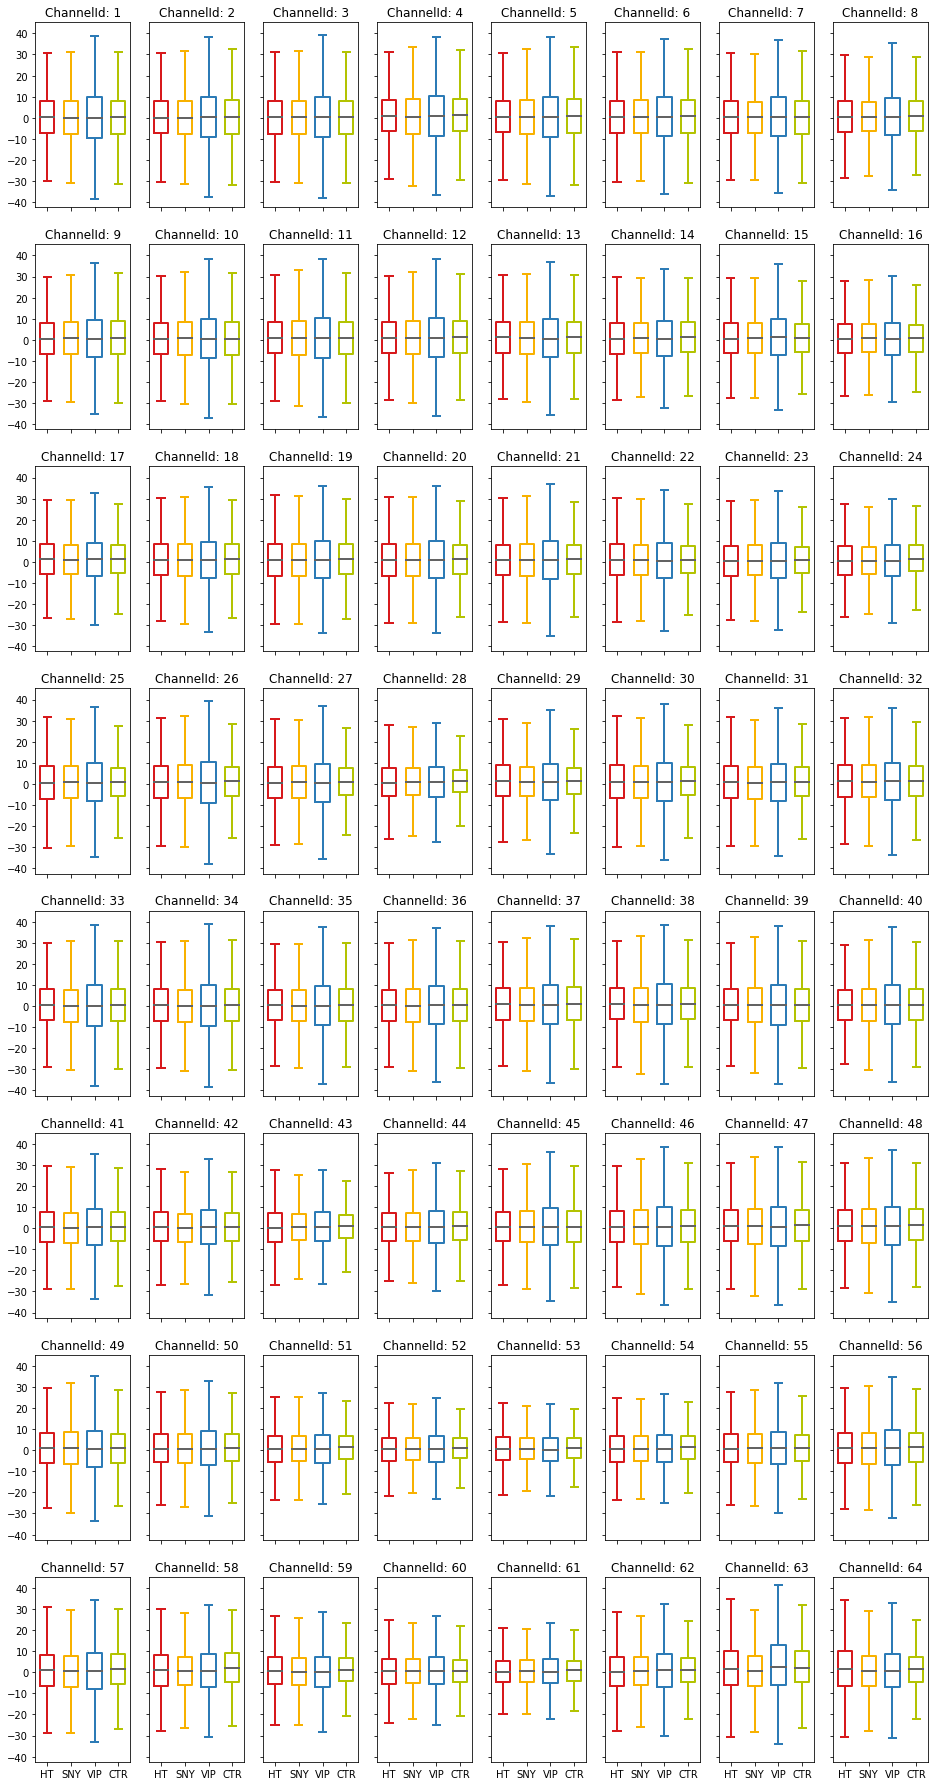

In [68]:
def set_box_color(bp, color):
    plt.setp(bp['boxes'], color=color, linewidth=2)
    plt.setp(bp['whiskers'], color=color, linewidth=2)
    plt.setp(bp['caps'], color=color, linewidth=2)
    plt.setp(bp['medians'], color="#636363", linewidth=2)

fig, axs = plt.subplots(8, 8, figsize=(16, 32))
boxprops = dict(linewidth=2)
bplot_colors = ['#D7191C', '#F8B100', '#2C7BB6', '#B3C302']

for channelidx in range(0, 64):
    rowidx = (channelidx//8)
    colidx = channelidx%8
    for _, med_tech in enumerate(dtype_names):
        subj_data = all_mats[med_tech][med_tech][:,1]
        channel_spec_data = np.array([])
        for subj in subj_data:
            channel_spec_data = np.append(channel_spec_data, subj[channelidx,:])
        bpl = axs[rowidx, colidx].boxplot(channel_spec_data, positions=[0+_], sym='', widths=0.6, boxprops=boxprops)
        set_box_color(bpl, bplot_colors[_])
        axs[rowidx, colidx].set_title('ChannelId: {}'.format(channelidx+1))
        axs[rowidx, colidx].sharex(axs[0, 0])
        axs[rowidx, colidx].sharey(axs[0, 0])

for ax in fig.get_axes():
    ax.label_outer();
plt.xticks(range(0, len(dtype_names)), dtype_names);

#fig.suptitle('Boxplots for each channel across the four groups: HT, SNY, VIP, CTR')

plt.savefig("figures/channelwise_boxplot_wo_outliers.png")

In [14]:
# def set_box_color(bp, color):
#     plt.setp(bp['boxes'], color=color, linewidth=2)
#     plt.setp(bp['whiskers'], color=color, linewidth=2)
#     plt.setp(bp['caps'], color=color, linewidth=2)
#     plt.setp(bp['medians'], color="#636363", linewidth=2)

# fig, axs = plt.subplots(9, 7, figsize=(16, 32))
# boxprops = dict(linewidth=2)
# bplot_colors = ['#D7191C', '#F8B100', '#2C7BB6', '#B3C302']

# for channelidx in range(0, 63):
#     rowidx = (channelidx//7)
#     colidx = channelidx%9
#     for _, med_tech in enumerate(dtype_names):
#         subj_data = all_mats[med_tech][med_tech][:,1]
#         channel_spec_data = np.array([])
#         for subj in subj_data:
#             channel_spec_data = np.append(channel_spec_data, subj[channelidx,:])
#         bpl = axs[rowidx, colidx].boxplot(channel_spec_data, positions=[0+_], sym='', widths=0.6, boxprops=boxprops)
#         set_box_color(bpl, bplot_colors[_])
#         axs[rowidx, colidx].set_title('ChannelId: {}'.format(channelidx+1))
#         axs[rowidx, colidx].sharex(axs[0, 0])
#         axs[rowidx, colidx].sharey(axs[0, 0])

# for ax in fig.get_axes():
#     ax.label_outer();
# plt.xticks(range(0, len(dtype_names)), dtype_names);

# #fig.suptitle('Boxplots for each channel across the four groups: HT, SNY, VIP, CTR')

# plt.savefig("figures/channelwise_boxplot_wo_outliers_new.png")

Similar results indicate that there is no specific channel which is significantly different for a specific group (meditaiton traditions HT, SYN, VIP, or the CTR)

Channels 1-16 show similar trends. From channel 17 onwards, more differences in the range of the amplitudes is observed. For most channels, maximum variation is observed in VIP tradition. The minimum range is observed in the CTR group across most channels.

However, when we plot the outliers, we see interesting patterns in the channel ids 18, 21, 26 for the VIP group, and 25, 26, 27, and 29 for the CTR group.

In [20]:
def truncate_to_equal_time_steps(all_mats):
    global_min = sys.maxsize
    global_min_args = []
    group_sizes = {med: [] for med in dtype_names}
    
    for med in dtype_names:
        for subj_idx, subj_data in enumerate(all_mats[med][med]):
#             if subj_idx == 8 and med == 'SNY':
#                 continue
            sub_min = subj_data[1].shape[1]
            group_sizes[med].append(sub_min)
            if sub_min < global_min:
                global_min = sub_min
                global_min_args = [med, subj_idx]
    return group_sizes, global_min, global_min_args
            
if debug:
    group_sizes, global_min, global_min_args = truncate_to_equal_time_steps(all_mats)
    print("Global min timestep size: {} for sub {} for group {}".format(global_min, global_min_args[1], global_min_args[0]))

Global min timestep size: 63616 for sub 8 for group SNY


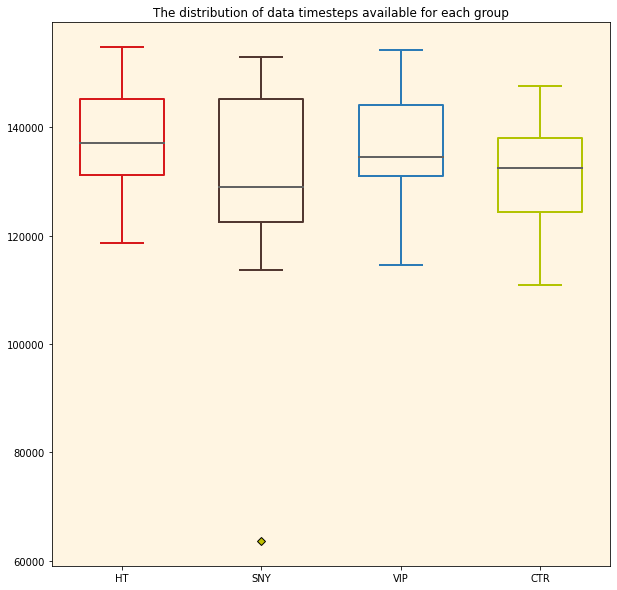

In [25]:
def plot_timesteps_per_group(group_sizes):
    
    fig = plt.figure(figsize=(10, 10))
    plt.rcParams['axes.facecolor'] = '#FFF5E2'
    boxprops = dict(linewidth=2)
    bplot_colors = ['#D7191C', '#523831', '#2C7BB6', '#B3C302']
    green_diamond = dict(markerfacecolor='y', marker='D')
    
    for _, med in enumerate(dtype_names):
        bpl = plt.boxplot(group_sizes[med], positions=[0+_], widths=0.6, boxprops=boxprops, flierprops=green_diamond)
        set_box_color(bpl, bplot_colors[_])
    plt.xticks(range(0, len(dtype_names)), dtype_names);
    plt.title('The distribution of data timesteps available for each group')
    
    plt.savefig("figures/group_wise_timesteps.png")
        
if debug:
    plot_timesteps_per_group(group_sizes)

In [ ]:
"Data from val/test users is unseen during train. Note this can only be used to do meditation technique classification, and user classification is impossible."

The smallest timesteps are availble for subject 8 for SNY technique group, and is a significant outlier. Most other timesteps lie within the 1.25 * IQR of Q1 and Q4, while this is less than half the minimum number of other timesteps.

In [7]:
def shuffle_together(x1, x2, x3=None, x4=None):
    if x3:
        if x4:
            zipped = list(zip(x1, x2, x3, x4))
            random.shuffle(zipped)
            x1, x2, x3, x4 = zip(*zipped)
            return x1, x2, x3, x4
        else:
            zipped = list(zip(x1, x2, x3))
            random.shuffle(zipped)
            x1, x2, x3 = zip(*zipped)
            return x1, x2, x3
    else:
        zipped = list(zip(x1, x2))
        random.shuffle(zipped)
        x1, x2 = zip(*zipped)
        return x1, x2

## 1. TIME SPLIT

#### 1.1 Split time based

In [8]:
def timeslot_crop_split(all_mats, crop_len=None):
    """Data for each subject is divided into 10 second chunks and chunks are randomly selected into train, val, and test set. This can be used to do meditation classification as well as user classification."""
    
    global_min = sys.maxsize
    global_min_args = []
    group_sizes = {med: [] for med in dtype_names}
    
    for med in dtype_names:
        for subj_idx, subj_data in enumerate(all_mats[med][med]):
            if subj_idx == 8 and med == 'SNY':
                continue
            sub_min = subj_data[1].shape[1]
            group_sizes[med].append(sub_min)
            if sub_min < global_min:
                global_min = sub_min
                global_min_args = [med, subj_idx]
                
    print(f"Global minimum is: {global_min}")
    if crop_len:
        global_min = crop_len
    
    print(f"Cropping the data to: {global_min}")
    
    global_subj_ctr = 0
    subjid_med_map = {}
    
    X_train = []
    y_train_subjid = []
    y_train_medid = []
    X_val = []
    y_val_subjid = []
    y_val_medid = []
    X_test = []
    y_test_subjid = []
    y_test_medid = []
    
    for med_idx, med in enumerate(dtype_names):
        
        for subj_idx, subj_data in enumerate(all_mats[med][med]):
            subj_specific_data = []
            
            # divide the step global_min/2 if we want to take chunks of time 10 seconds but overlapping window of 5 seconds to create sequences. 
            for crop_idx in range(0, subj_data[1].shape[1], global_min):
                
                # Range exceeded
                if crop_idx+global_min >= subj_data[1].shape[1]:
                    continue
                
                sub_data_cropped = subj_data[1][:, 0+crop_idx:crop_idx+global_min]
                subj_specific_data.append(sub_data_cropped)
            
            random.shuffle(subj_specific_data)
            val_begin_idx = int(len(subj_specific_data)*0.6)
            val_end_idx = int(len(subj_specific_data)*0.8)
            
            X_train += subj_specific_data[:val_begin_idx]
            y_train_medid += ([med_idx]*len(subj_specific_data[:val_begin_idx]))
            y_train_subjid += ([global_subj_ctr]*len(subj_specific_data[:val_begin_idx]))
            
            X_val += subj_specific_data[val_begin_idx: val_end_idx]
            y_val_medid += ([med_idx]*len(subj_specific_data[val_begin_idx: val_end_idx]))
            y_val_subjid += ([global_subj_ctr]*len(subj_specific_data[val_begin_idx: val_end_idx]))
            
            X_test += subj_specific_data[val_end_idx:]
            y_test_medid += ([med_idx]*len(subj_specific_data[val_end_idx:]))
            y_test_subjid += ([global_subj_ctr]*len(subj_specific_data[val_end_idx:]))
            
            subjid_med_map[global_subj_ctr] = med
            global_subj_ctr += 1

    X_train, y_train_medid, y_train_subjid = shuffle_together(X_train, y_train_medid, y_train_subjid)
    X_val, y_val_medid, y_val_subjid = shuffle_together(X_val, y_val_medid, y_val_subjid)
    X_test, y_test_medid, y_test_subjid = shuffle_together(X_test, y_test_medid, y_test_subjid)
    
    with open('./data/Meditation/time_based_splits.pkl', 'wb') as f:
        all_data_splits = {'train': {'x': np.array(X_train), 'y_med': np.array(y_train_medid), 'y_subj': np.array(y_train_subjid)}, 
                          'val': {'x': np.array(X_val), 'y_med': np.array(y_val_medid), 'y_subj': np.array(y_val_subjid)},
                          'test': {'x': np.array(X_test), 'y_med': np.array(y_test_medid), 'y_subj': np.array(y_test_subjid)}}
        pickle.dump(all_data_splits, f)
        
    return X_train, y_train_medid, y_train_subjid, X_val, y_val_medid, y_val_subjid, X_test, y_test_medid, y_test_subjid
    
if debug:
    # 2560 timesteps mean that we have taken 10 minute chunks, as the sampling frequency is 256Hz.
    X_train, y_train_medid, y_train_subjid, X_val, y_val_medid, y_val_subjid, X_test, y_test_medid, y_test_subjid = timeslot_crop_split(all_mats, crop_len=2560)

Global minimum is: 110976
Cropping the data to: 2560


In [9]:
Counter(y_train_medid), Counter(y_val_medid), Counter(y_test_medid)

(Counter({3: 479, 1: 471, 2: 500, 0: 504}),
 Counter({2: 167, 1: 160, 0: 171, 3: 163}),
 Counter({0: 177, 3: 171, 1: 164, 2: 176}))

In [125]:
Counter(y_train_medid), Counter(y_val_medid), Counter(y_test_medid)

(Counter({0: 504, 1: 471, 2: 500, 3: 479}),
 Counter({0: 171, 1: 160, 2: 167, 3: 163}),
 Counter({0: 177, 1: 164, 2: 176, 3: 171}))

In [10]:
len(X_train), len(X_val), len(X_test)

(1954, 661, 688)

In [11]:
X_train[0].shape

(64, 2560)

In [133]:
X_train = np.array(X_train)

In [134]:
X_train.shape

(1954, 64, 2560)

#### 1.2 Split time based and keep timeidx in time_splits

In [9]:
def timeslot_crop_split_with_timestamp(all_mats, crop_len=None):
    """Data for each subject is divided into 10 second chunks and chunks are randomly selected into train, val, and test set. This can be used to do meditation classification as well as user classification."""
    
    global_min = sys.maxsize
    global_min_args = []
    group_sizes = {med: [] for med in dtype_names}
    
    for med in dtype_names:
        for subj_idx, subj_data in enumerate(all_mats[med][med]):
            if subj_idx == 8 and med == 'SNY':
                continue
            sub_min = subj_data[1].shape[1]
            group_sizes[med].append(sub_min)
            if sub_min < global_min:
                global_min = sub_min
                global_min_args = [med, subj_idx]
                
    print(f"Global minimum is: {global_min}")
    if crop_len:
        global_min = crop_len
    
    print(f"Cropping the data to: {global_min}")
    
    global_subj_ctr = 0
    subjid_med_map = {}
    
    X_train = []
    y_train_subjid = []
    y_train_medid = []
    y_train_ts = []
    
    X_val = []
    y_val_subjid = []
    y_val_medid = []
    y_val_ts = []
    
    X_test = []
    y_test_subjid = []
    y_test_medid = []
    y_test_ts = []
    
    for med_idx, med in enumerate(dtype_names):
        
        for subj_idx, subj_data in enumerate(all_mats[med][med]):
            subj_specific_data = []
            time_ids_for_data = []
            timestep_idx = 0
            
            # divide the step global_min/2 if we want to take chunks of time 10 seconds but overlapping window of 5 seconds to create sequences. 
            for crop_idx in range(0, subj_data[1].shape[1], global_min):
                
                # Range exceeded
                if crop_idx+global_min >= subj_data[1].shape[1]:
                    continue
                
                sub_data_cropped = subj_data[1][:, 0+crop_idx:crop_idx+global_min]
                subj_specific_data.append(sub_data_cropped)
                time_ids_for_data.append("{}_{}_{}".format(med_idx, subj_idx, timestep_idx))
                timestep_idx += 1
            
            
            subj_timeid_data = list(zip(subj_specific_data, time_ids_for_data))
            random.shuffle(subj_timeid_data)
            subj_specific_data, time_ids_for_data = zip(*subj_timeid_data)
            val_begin_idx = int(len(subj_specific_data)*0.6)
            val_end_idx = int(len(subj_specific_data)*0.8)
            
            X_train += subj_specific_data[:val_begin_idx]
            y_train_medid += ([med_idx]*len(subj_specific_data[:val_begin_idx]))
            y_train_subjid += ([global_subj_ctr]*len(subj_specific_data[:val_begin_idx]))
            y_train_ts += time_ids_for_data[:val_begin_idx]
            
            X_val += subj_specific_data[val_begin_idx: val_end_idx]
            y_val_medid += ([med_idx]*len(subj_specific_data[val_begin_idx: val_end_idx]))
            y_val_subjid += ([global_subj_ctr]*len(subj_specific_data[val_begin_idx: val_end_idx]))
            y_val_ts += time_ids_for_data[val_begin_idx: val_end_idx]
            
            X_test += subj_specific_data[val_end_idx:]
            y_test_medid += ([med_idx]*len(subj_specific_data[val_end_idx:]))
            y_test_subjid += ([global_subj_ctr]*len(subj_specific_data[val_end_idx:]))
            y_test_ts += time_ids_for_data[val_end_idx:]
            
            subjid_med_map[global_subj_ctr] = med
            global_subj_ctr += 1

    X_train, y_train_medid, y_train_subjid, y_train_ts = shuffle_together(X_train, y_train_medid, y_train_subjid, y_train_ts)
    X_val, y_val_medid, y_val_subjid, y_val_ts = shuffle_together(X_val, y_val_medid, y_val_subjid, y_val_ts)
    X_test, y_test_medid, y_test_subjid, y_test_ts = shuffle_together(X_test, y_test_medid, y_test_subjid, y_test_ts)
    
    with open('./data/Meditation/time_based_splits_with_timestamp.pkl', 'wb') as f:
        all_data_splits = {'train': {'x': np.array(X_train), 'y_med': np.array(y_train_medid), 'y_subj': np.array(y_train_subjid), 'y_ts': np.array(y_train_ts)}, 
                          'val': {'x': np.array(X_val), 'y_med': np.array(y_val_medid), 'y_subj': np.array(y_val_subjid), 'y_ts': np.array(y_val_ts)},
                          'test': {'x': np.array(X_test), 'y_med': np.array(y_test_medid), 'y_subj': np.array(y_test_subjid), 'y_ts': np.array(y_test_ts)}}
        pickle.dump(all_data_splits, f)
        
    return X_train, y_train_medid, y_train_subjid, y_train_ts, X_val, y_val_medid, y_val_subjid, y_val_ts, X_test, y_test_medid, y_test_subjid, y_test_ts
    
if debug:
    # 2560 timesteps mean that we have taken 10 minute chunks, as the sampling frequency is 256Hz.
    X_train, y_train_medid, y_train_subjid, y_train_ts, X_val, y_val_medid, y_val_subjid, y_val_ts, X_test, y_test_medid, y_test_subjid, y_test_ts = timeslot_crop_split_with_timestamp(all_mats, crop_len=2560)

Global minimum is: 110976
Cropping the data to: 2560


Next step: (i) Split each data point into 4-5 partitions so that the data is now increased. (ii) Shuffle the dataset by putting it into a dataframe - collated x and y, and figure out how to shuffle X which is 2dim. (iii) Check data shape compatibility with the EEGNet and then feed to it and then train.

## 2. USER SPLIT

### 2.1 Keep data with med tech and sub id labels

In [12]:
def user_dependent_crop_split(all_mats, crop_len=None):
    "Data from val/test users is unseen during train. Note this can only be used to do meditation technique classification, and user classification is impossible."
    
    global_min = sys.maxsize
    global_min_args = []
    group_sizes = {med: [] for med in dtype_names}
    
    for med in dtype_names:
        for subj_idx, subj_data in enumerate(all_mats[med][med]):
            if subj_idx == 8 and med == 'SNY':
                continue
            sub_min = subj_data[1].shape[1]
            group_sizes[med].append(sub_min)
            if sub_min < global_min:
                global_min = sub_min
                global_min_args = [med, subj_idx]
                
    print(f"Global minimum is: {global_min}")
    if crop_len:
        global_min = crop_len
    
    print(f"Cropping the data to: {global_min}")
    
    global_subj_ctr = 0
    subjid_med_map = {}
    
    X_train = []
    y_train_subjid = []
    y_train_medid = []
    X_val = []
    y_val_subjid = []
    y_val_medid = []
    X_test = []
    y_test_subjid = []
    y_test_medid = []
    
    for med_idx, med in enumerate(dtype_names):
        train_ctr = 0
        test_ctr = 0
        
        for subj_idx, subj_data in enumerate(all_mats[med][med]):
            #if subj_idx == 8 and med == 'SNY':
            #    continue
            
            for crop_idx in range(0, subj_data[1].shape[1], global_min):
                # Range exceeded
                if crop_idx+global_min >= subj_data[1].shape[1]:
                    continue
                sub_data_cropped = subj_data[1][:, 0+crop_idx:crop_idx+global_min]
                if subj_idx < 10:
                    X_train.append(sub_data_cropped)
                    y_train_medid.append(med_idx)
                    y_train_subjid.append(global_subj_ctr)
                    train_ctr += 1
                elif subj_idx < 13:
                    X_test.append(sub_data_cropped)
                    y_test_medid.append(med_idx)
                    y_test_subjid.append(global_subj_ctr)
                    test_ctr += 1
                else:
                    X_val.append(sub_data_cropped)
                    y_val_medid.append(med_idx)
                    y_val_subjid.append(global_subj_ctr)
            
            subjid_med_map[global_subj_ctr] = med
            global_subj_ctr += 1
    
    X_train, y_train_medid, y_train_subjid = shuffle_together(X_train, y_train_medid, y_train_subjid)
    X_val, y_val_medid, y_val_subjid = shuffle_together(X_val, y_val_medid, y_val_subjid)
    X_test, y_test_medid, y_test_subjid = shuffle_together(X_test, y_test_medid, y_test_subjid)

    with open('./data/Meditation/user_based_splits.pkl', 'wb') as f:
        all_data_splits = {'train': {'x': np.array(X_train), 'y_med': np.array(y_train_medid), 'y_subj': np.array(y_train_subjid)}, 
                          'val': {'x': np.array(X_val), 'y_med': np.array(y_val_medid), 'y_subj': np.array(y_val_subjid)},
                          'test': {'x': np.array(X_test), 'y_med': np.array(y_test_medid), 'y_subj': np.array(y_test_subjid)}}
        pickle.dump(all_data_splits, f)
    
    return X_train, y_train_medid, y_train_subjid, X_val, y_val_medid, y_val_subjid, X_test, y_test_medid, y_test_subjid
    
if debug:
    # 2560 timesteps mean that we have taken 10 minute chunks, as the sampling frequency is 256Hz.
    X_train, y_train_medid, y_train_subjid, X_val, y_val_medid, y_val_subjid, X_test, y_test_medid, y_test_subjid = user_dependent_crop_split(all_mats, crop_len=2560)

Global minimum is: 110976
Cropping the data to: 2560


In [14]:
#Counter(y_train_subjid), 
Counter(y_val_subjid), Counter(y_test_subjid)

(Counter({47: 49,
          15: 55,
          30: 46,
          61: 48,
          45: 52,
          13: 51,
          14: 53,
          46: 52,
          29: 55,
          62: 56,
          31: 57,
          63: 57}),
 Counter({42: 56,
          12: 50,
          60: 56,
          10: 56,
          58: 51,
          11: 47,
          28: 50,
          44: 44,
          59: 43,
          26: 58,
          43: 56,
          27: 48}))

In [15]:
#Counter(y_train_subjid), 
Counter(y_val_medid), Counter(y_test_medid)

(Counter({2: 153, 0: 159, 1: 158, 3: 161}),
 Counter({2: 156, 0: 153, 3: 150, 1: 156}))

### 2.2 Keep data with timestamp, med_tech, and subj_id

In [10]:
def user_dependent_crop_split_with_timestamp(all_mats, crop_len=None):
    "Data from val/test users is unseen during train. Note this can only be used to do meditation technique classification, and user classification is impossible."
    
    global_min = sys.maxsize
    global_min_args = []
    group_sizes = {med: [] for med in dtype_names}
    
    for med in dtype_names:
        for subj_idx, subj_data in enumerate(all_mats[med][med]):
            if subj_idx == 8 and med == 'SNY':
                continue
            sub_min = subj_data[1].shape[1]
            group_sizes[med].append(sub_min)
            if sub_min < global_min:
                global_min = sub_min
                global_min_args = [med, subj_idx]
                
    print(f"Global minimum is: {global_min}")
    if crop_len:
        global_min = crop_len
    
    print(f"Cropping the data to: {global_min}")
    
    global_subj_ctr = 0
    subjid_med_map = {}
    
    X_train = []
    y_train_subjid = []
    y_train_medid = []
    y_train_ts = []
    
    X_val = []
    y_val_subjid = []
    y_val_medid = []
    y_val_ts = []
    
    X_test = []
    y_test_subjid = []
    y_test_medid = []
    y_test_ts = []
    
    for med_idx, med in enumerate(dtype_names):
        train_ctr = 0
        test_ctr = 0
        
        for subj_idx, subj_data in enumerate(all_mats[med][med]):
            time_ids_for_data = []
            timestep_idx = 0
            
            #if subj_idx == 8 and med == 'SNY':
            #    continue
            
            for crop_idx in range(0, subj_data[1].shape[1], global_min):
                # Range exceeded
                if crop_idx+global_min >= subj_data[1].shape[1]:
                    continue
                sub_data_cropped = subj_data[1][:, 0+crop_idx:crop_idx+global_min]
                if subj_idx < 10:
                    X_train.append(sub_data_cropped)
                    y_train_medid.append(med_idx)
                    y_train_subjid.append(global_subj_ctr)
                    y_train_ts.append("{}_{}_{}".format(med_idx, subj_idx, timestep_idx))
                    timestep_idx += 1
                    train_ctr += 1
                elif subj_idx < 13:
                    X_test.append(sub_data_cropped)
                    y_test_medid.append(med_idx)
                    y_test_subjid.append(global_subj_ctr)
                    y_test_ts.append("{}_{}_{}".format(med_idx, subj_idx, timestep_idx))
                    timestep_idx += 1
                    test_ctr += 1
                else:
                    X_val.append(sub_data_cropped)
                    y_val_medid.append(med_idx)
                    y_val_subjid.append(global_subj_ctr)
                    y_val_ts.append("{}_{}_{}".format(med_idx, subj_idx, timestep_idx))
                    timestep_idx += 1
            
            subjid_med_map[global_subj_ctr] = med
            global_subj_ctr += 1
    
    X_train, y_train_medid, y_train_subjid, y_train_ts = shuffle_together(X_train, y_train_medid, y_train_subjid, y_train_ts)
    X_val, y_val_medid, y_val_subjid, y_val_ts = shuffle_together(X_val, y_val_medid, y_val_subjid, y_val_ts)
    X_test, y_test_medid, y_test_subjid, y_test_ts = shuffle_together(X_test, y_test_medid, y_test_subjid, y_test_ts)

    with open('./data/Meditation/user_based_splits_with_timestamp.pkl', 'wb') as f:
        all_data_splits = {'train': {'x': np.array(X_train), 'y_med': np.array(y_train_medid), 'y_subj': np.array(y_train_subjid), 'y_ts': np.array(y_train_ts)}, 
                          'val': {'x': np.array(X_val), 'y_med': np.array(y_val_medid), 'y_subj': np.array(y_val_subjid), 'y_ts': np.array(y_val_ts)},
                          'test': {'x': np.array(X_test), 'y_med': np.array(y_test_medid), 'y_subj': np.array(y_test_subjid), 'y_ts': np.array(y_test_ts)}}
        pickle.dump(all_data_splits, f)
    
    return X_train, y_train_medid, y_train_subjid, y_train_ts, X_val, y_val_medid, y_val_subjid, y_val_ts, X_test, y_test_medid, y_test_subjid, y_test_ts
    
if debug:
    # 2560 timesteps mean that we have taken 10 minute chunks, as the sampling frequency is 256Hz.
    X_train, y_train_medid, y_train_subjid, y_train_ts, X_val, y_val_medid, y_val_subjid, y_val_ts, X_test, y_test_medid, y_test_subjid, y_test_ts = user_dependent_crop_split_with_timestamp(all_mats, crop_len=2560)

Global minimum is: 110976
Cropping the data to: 2560


In [ ]:
_